In [21]:
import random
import numpy
import torch
import os, sys
from DLStudio import *
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as tvt
import time


seed = 0           
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmarks=False
os.environ['PYTHONHASHSEED'] = str(seed)

In [61]:
class CustomizedSemanticSegmentation(DLStudio.SemanticSegmentation):
    def __init__(self, dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None, **kwargs):
        """In addition to the original DLStudio.SemanticSegmentation, it takes a keyboard argument 'loss' which takes values 
        of 'MSE', 'Dice', and 'Combined' to use different loss functions. Further the run_code_for_training_for_semantic_segmentation returns
        the loss values. """
        
        super().__init__(dl_studio, max_num_objects, dataserver_train=None, dataserver_test=None, dataset_file_train=None, dataset_file_test=None)
        self.loss= 'MSE'
        if 'loss' in kwargs:
            self.loss= kwargs.pop('loss')
        if len(kwargs)!=0 :
            raise ValueError('''Keyword argument not recognized''') 
        if self.loss not in ['MSE', 'Dice', 'Combined']:
            raise ValueError("The keyboard argument 'loss' takes only one of the following values: ['MSE', 'Dice', 'Combined']")

    def dice_loss(self, preds: torch.Tensor, ground_truth: torch.Tensor, epsilon=1e-6): #defining dice_loss
        """
        Compute the Dice loss between predicted masks and ground truth masks.
        
        Args:
        - preds (torch.Tensor): Predicted mask tensor.
        - ground_truth (torch.Tensor): Ground truth mask tensor.
        - epsilon (float): Small value to avoid division by zero.
        
        Returns:
        - dice_loss: Dice loss value.
        """
        numerator= torch.sum(preds*ground_truth)
        denominator= torch.sum(preds*preds) + torch.sum(ground_truth * ground_truth)
        dice_coefficient= 2*numerator/(denominator+epsilon)
        

        dice_loss= 1-dice_coefficient
        
        return dice_loss                  
        
        
    def run_code_for_training_for_semantic_segmentation(self, net, **kwargs): 
            loss_fn= 'MSE'
            if 'loss' in kwargs:
                loss_fn= kwargs.pop('loss')
            if len(kwargs)!=0 :
                raise ValueError('''Keyword argument not recognized''') 
            if loss_fn not in ['MSE', 'Dice', 'Combined']:
                raise ValueError("The keyboard argument 'loss' takes only one of the following values: ['MSE', 'Dice', 'Combined']")       
            filename_for_out1 = "performance_numbers_" + str(self.dl_studio.epochs) + ".txt"
            FILE1 = open(filename_for_out1, 'w')
            net = copy.deepcopy(net)
            net = net.to(self.dl_studio.device)
            criterion1 = nn.MSELoss()
            optimizer = optim.SGD(net.parameters(), 
                         lr=self.dl_studio.learning_rate, momentum=self.dl_studio.momentum)
            running_loss_record=[]
            start_time = time.perf_counter()
            for epoch in range(self.dl_studio.epochs):  
                print("")
                running_loss_segmentation = 0.0
                for i, data in enumerate(self.train_dataloader):    
                    im_tensor,mask_tensor,bbox_tensor =data['image'],data['mask_tensor'],data['bbox_tensor']
                    im_tensor   = im_tensor.to(self.dl_studio.device)
                    mask_tensor = mask_tensor.type(torch.FloatTensor)
                    mask_tensor = mask_tensor.to(self.dl_studio.device)                 
                    bbox_tensor = bbox_tensor.to(self.dl_studio.device)
                    optimizer.zero_grad()
                    output = net(im_tensor) 
                    if loss_fn=='MSE':  #using MSE loss
                        segmentation_loss = criterion1(output, mask_tensor)  
                    if loss_fn=='Dice':  #using Dice Loss
                        segmentation_loss = self.dice_loss(output, mask_tensor)  
                    if loss_fn=="Combined":  #using Combined Loss
                        segmentation_loss = criterion1(output, mask_tensor) + 20*self.dice_loss(output, mask_tensor) 
                    
                    
                    segmentation_loss.backward()
                    optimizer.step()
                    running_loss_segmentation += segmentation_loss.item()   
                    # running_loss_record.append(segmentation_loss.item()) 
                    if i%500==499:    
                        current_time = time.perf_counter()
                        elapsed_time = current_time - start_time
                        avg_loss_segmentation = running_loss_segmentation / float(500)
                        running_loss_record.append(avg_loss_segmentation)
                        print("[epoch=%d/%d, iter=%4d  elapsed_time=%3d secs]  Loss: %.3f" % (epoch+1, self.dl_studio.epochs, i+1, elapsed_time, avg_loss_segmentation))
                        FILE1.write("%.3f\n" % avg_loss_segmentation)
                        FILE1.flush()
                        running_loss_segmentation = 0.0
            print("\nFinished Training\n")
            self.save_model(net)
            return running_loss_record #returning loss values


In [62]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/PurdueShapes5MultiObject/",
                  dataroot = "/local/scratch/a/oachary/Classes/Semester2/ECE60146/Datasets/data/",
                  image_size = [64,64],
                  path_saved_model = "./saved_model",
                  momentum = 0.9,
                  learning_rate = 1e-4,
                  epochs = 6,
                  batch_size = 4,
                  classes = ('rectangle','triangle','disk','oval','star'),
                  use_gpu = True,
              )

In [63]:
segmenter = CustomizedSemanticSegmentation( 
                  dl_studio = dls,
                  max_num_objects=5
                  
              )

In [45]:
dataserver_train = CustomizedSemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'train',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-10000-train.gz", 
                        )
dataserver_test = CustomizedSemanticSegmentation.PurdueShapes5MultiObjectDataset(
                          train_or_test = 'test',
                          dl_studio = dls,
                          segmenter = segmenter,
                          dataset_file = "PurdueShapes5MultiObject-1000-test.gz"
                        )
segmenter.dataserver_train = dataserver_train
segmenter.dataserver_test = dataserver_test




Loading training data from torch saved file


In [66]:
segmenter.load_PurdueShapes5MultiObject_dataset(dataserver_train, dataserver_test)

In [67]:
model_MSE = segmenter.mUnet(skip_connections=True, depth=16)

In [68]:
train_losses_MSE=segmenter.run_code_for_training_for_semantic_segmentation(model_MSE)

[epoch=1/6, iter= 500  elapsed_time= 19 secs]  Loss: 439.278
[epoch=1/6, iter=1000  elapsed_time= 38 secs]  Loss: 416.502
[epoch=1/6, iter=1500  elapsed_time= 57 secs]  Loss: 402.222
[epoch=1/6, iter=2000  elapsed_time= 76 secs]  Loss: 391.384
[epoch=1/6, iter=2500  elapsed_time= 97 secs]  Loss: 382.975

[epoch=2/6, iter= 500  elapsed_time=120 secs]  Loss: 379.007
[epoch=2/6, iter=1000  elapsed_time=139 secs]  Loss: 376.422
[epoch=2/6, iter=1500  elapsed_time=158 secs]  Loss: 377.437
[epoch=2/6, iter=2000  elapsed_time=177 secs]  Loss: 368.608
[epoch=2/6, iter=2500  elapsed_time=196 secs]  Loss: 368.020

[epoch=3/6, iter= 500  elapsed_time=215 secs]  Loss: 365.460
[epoch=3/6, iter=1000  elapsed_time=234 secs]  Loss: 373.554
[epoch=3/6, iter=1500  elapsed_time=253 secs]  Loss: 365.287
[epoch=3/6, iter=2000  elapsed_time=272 secs]  Loss: 360.037
[epoch=3/6, iter=2500  elapsed_time=291 secs]  Loss: 366.023

[epoch=4/6, iter= 500  elapsed_time=310 secs]  Loss: 356.290
[epoch=4/6, iter=1000

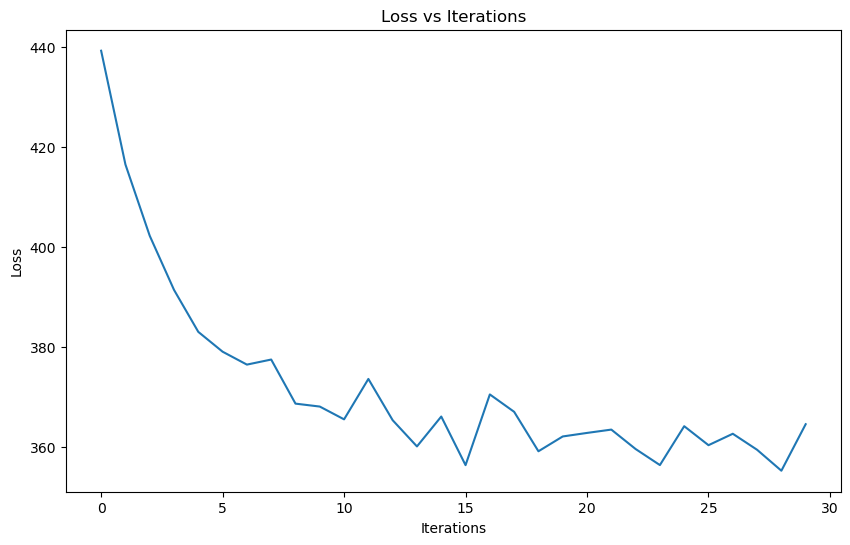

In [79]:
import matplotlib.pyplot as plt
figure, ax= plt.subplots(1, figsize= (10, 6))
ax.plot(train_losses_MSE)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iterations')
plt.show()





Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


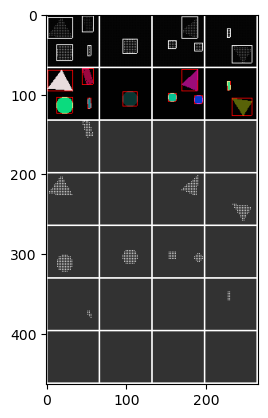





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


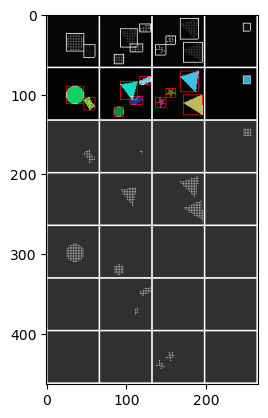





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


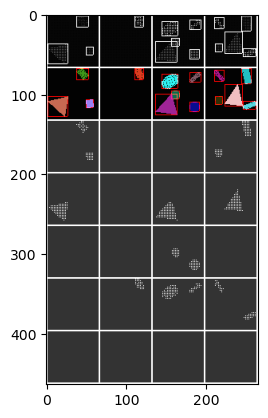





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


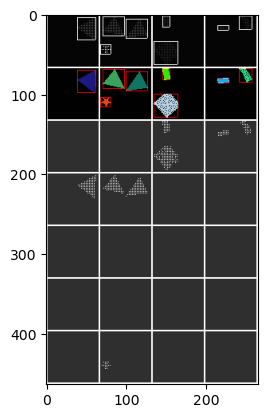





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


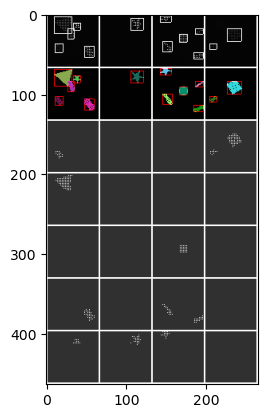

In [71]:
segmenter.run_code_for_testing_semantic_segmentation(model_MSE)

In [72]:
model_Dice = segmenter.mUnet(skip_connections=True, depth=16)

In [73]:
train_losses_Dice=segmenter.run_code_for_training_for_semantic_segmentation(model_Dice, loss='Dice')

[epoch=1/6, iter= 500  elapsed_time= 19 secs]  Loss: 0.984
[epoch=1/6, iter=1000  elapsed_time= 38 secs]  Loss: 0.856
[epoch=1/6, iter=1500  elapsed_time= 57 secs]  Loss: 0.816
[epoch=1/6, iter=2000  elapsed_time= 76 secs]  Loss: 0.803
[epoch=1/6, iter=2500  elapsed_time= 95 secs]  Loss: 0.790

[epoch=2/6, iter= 500  elapsed_time=115 secs]  Loss: 0.791
[epoch=2/6, iter=1000  elapsed_time=134 secs]  Loss: 0.782
[epoch=2/6, iter=1500  elapsed_time=153 secs]  Loss: 0.785
[epoch=2/6, iter=2000  elapsed_time=172 secs]  Loss: 0.780
[epoch=2/6, iter=2500  elapsed_time=191 secs]  Loss: 0.773

[epoch=3/6, iter= 500  elapsed_time=211 secs]  Loss: 0.774
[epoch=3/6, iter=1000  elapsed_time=230 secs]  Loss: 0.775
[epoch=3/6, iter=1500  elapsed_time=249 secs]  Loss: 0.770
[epoch=3/6, iter=2000  elapsed_time=269 secs]  Loss: 0.770
[epoch=3/6, iter=2500  elapsed_time=288 secs]  Loss: 0.767

[epoch=4/6, iter= 500  elapsed_time=307 secs]  Loss: 0.767
[epoch=4/6, iter=1000  elapsed_time=326 secs]  Loss: 

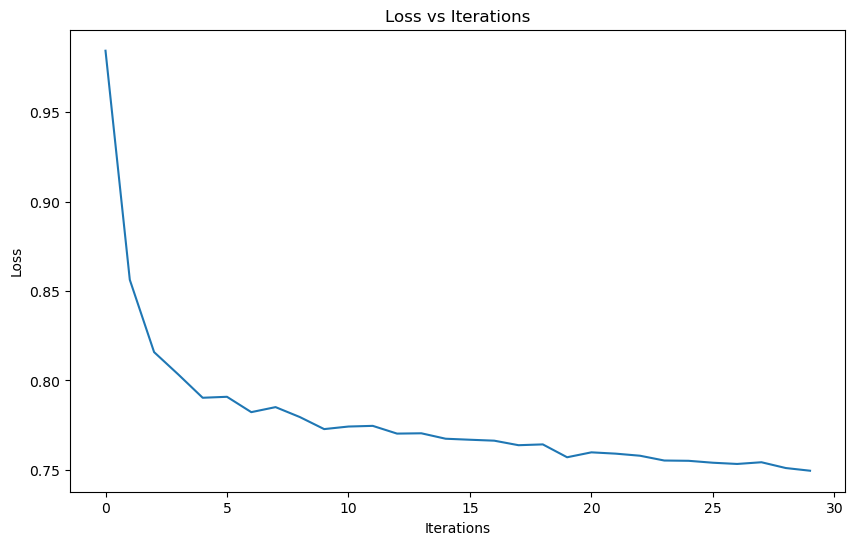

In [80]:
figure, ax= plt.subplots(1, figsize= (10, 6))
ax.plot(train_losses_Dice)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iterations')
plt.show()





Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


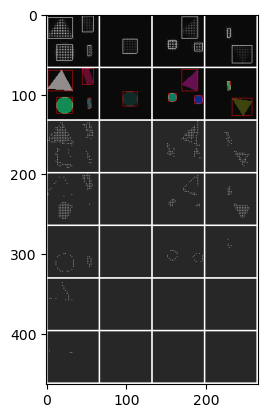





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


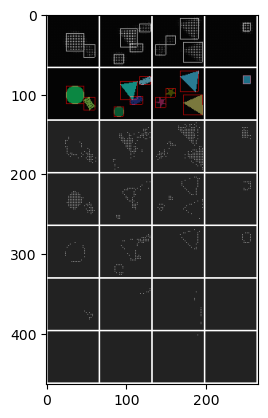





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


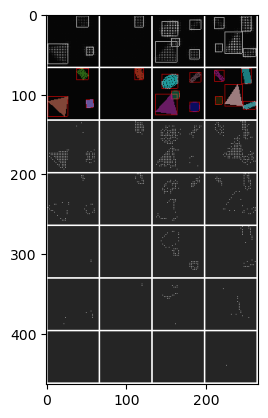





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


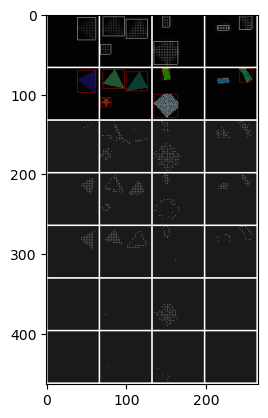





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


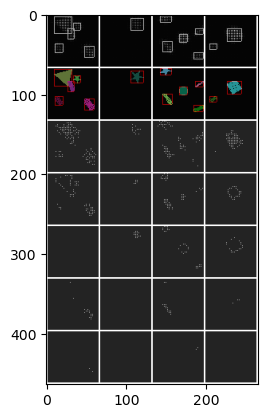

In [74]:
segmenter.run_code_for_testing_semantic_segmentation(model_Dice)

In [75]:
model_Combined = segmenter.mUnet(skip_connections=True, depth=16)

In [76]:
train_losses_Combined=segmenter.run_code_for_training_for_semantic_segmentation(model_Combined, loss='Combined')

[epoch=1/6, iter= 500  elapsed_time= 19 secs]  Loss: 462.403
[epoch=1/6, iter=1000  elapsed_time= 38 secs]  Loss: 423.526
[epoch=1/6, iter=1500  elapsed_time= 57 secs]  Loss: 416.782
[epoch=1/6, iter=2000  elapsed_time= 77 secs]  Loss: 400.325
[epoch=1/6, iter=2500  elapsed_time= 96 secs]  Loss: 404.297

[epoch=2/6, iter= 500  elapsed_time=115 secs]  Loss: 388.601
[epoch=2/6, iter=1000  elapsed_time=134 secs]  Loss: 397.873
[epoch=2/6, iter=1500  elapsed_time=153 secs]  Loss: 383.805
[epoch=2/6, iter=2000  elapsed_time=173 secs]  Loss: 380.724
[epoch=2/6, iter=2500  elapsed_time=192 secs]  Loss: 385.208

[epoch=3/6, iter= 500  elapsed_time=211 secs]  Loss: 385.898
[epoch=3/6, iter=1000  elapsed_time=231 secs]  Loss: 375.847
[epoch=3/6, iter=1500  elapsed_time=250 secs]  Loss: 387.176
[epoch=3/6, iter=2000  elapsed_time=269 secs]  Loss: 375.642
[epoch=3/6, iter=2500  elapsed_time=288 secs]  Loss: 368.338

[epoch=4/6, iter= 500  elapsed_time=308 secs]  Loss: 383.285
[epoch=4/6, iter=1000

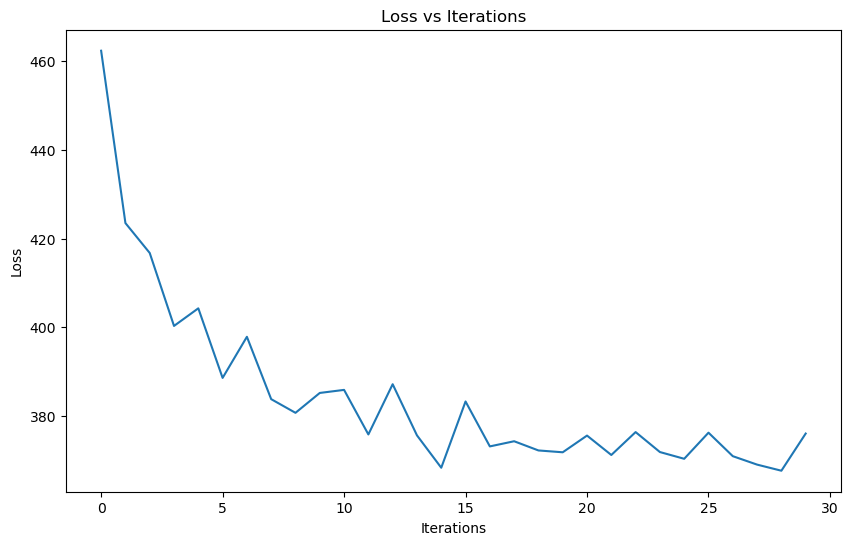

In [81]:
figure, ax= plt.subplots(1, figsize= (10, 6))
ax.plot(train_losses_Combined)
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iterations')
plt.show()





Showing output for test batch 1: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


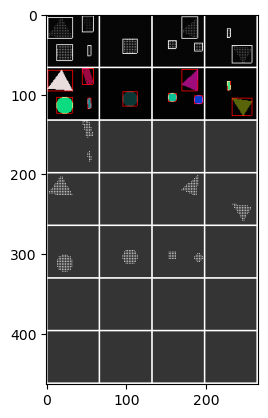





Showing output for test batch 51: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


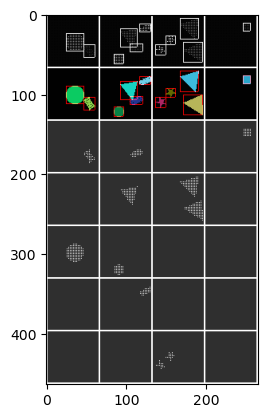





Showing output for test batch 101: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


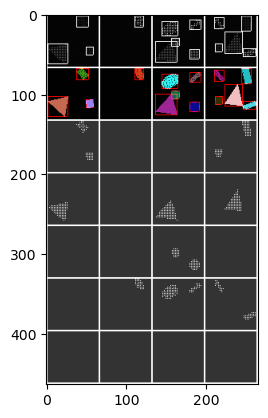





Showing output for test batch 151: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


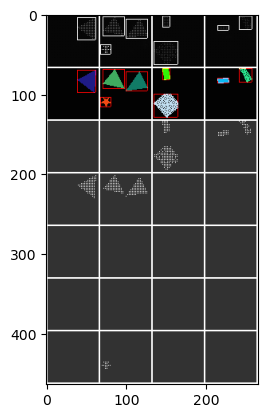





Showing output for test batch 201: 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


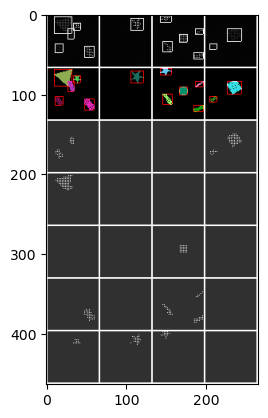

In [77]:
segmenter.run_code_for_testing_semantic_segmentation(model_Combined)